## Illustrate Explainability with Predictive Densities
Author: Clara Hoffmann \
Overview:
1. Load packages and data
2. Compute predictive densities
3. Plot predictive densities
4. Plot images

In [1]:
# load packages
import cv2
import imageio
import pandas as pd
import numpy as np
from helpers_trans import DensityPredictor
import matplotlib.pyplot as plt

In [2]:
# load density
density_path = '../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [3]:
path_all_imgs = '../../../data/commaai/training_files_filtered/indices/train_indices.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../data/commaai/train_bags_2/'
paths = img_path_base + all_img_df['path'][0:5]

In [4]:
path_all_imgs = '../../../data/commaai/training_files_filtered/indices/review.csv'
review_df_test = pd.read_csv(path_all_imgs)

In [21]:
# paths of images that interest us
paths = ['../../../data/commaai/train_bags_2/0/80_436run1.png', # parting road, closer
         '../../../data/commaai/train_bags_2/0/121_254run1.png', # parting road, closer, other side
        '../../../data/commaai/train_bags_2/0/118_977run1.png', # left turn only half visible
        ]

## 2. Compute predictive densities

In [6]:
# predictive densities ridge prior + va
predictor_va_prec = DensityPredictor('va_ridge', 'precise', 10)
predictor_va_prec.load_bzeta_model()
predictor_va_prec.predict_Bzeta(paths, True, False)
predictor_va_prec.choose_method('va_ridge')
predictor_va_prec.initialize_grid(density, 65536)
densities_va_prec = predictor_va_prec.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [7]:
# predictive densities horseshoe prior + hmc
predictor_hmc_prec_horse = DensityPredictor('hmc_horseshoe', 'precise', 10)
predictor_hmc_prec_horse.load_bzeta_model()
predictor_hmc_prec_horse.predict_Bzeta(paths, True, False)
predictor_hmc_prec_horse.choose_method('hmc_horseshoe')
predictor_hmc_prec_horse.initialize_grid(density, 65536)
densities_hmc_prec_horse = predictor_hmc_prec_horse.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose hmc with horseshoe prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [8]:
# predictive densities horseshoe prior + va
predictor_va_prec_horse = DensityPredictor('va_horseshoe', 'precise', 10)
predictor_va_prec_horse.load_bzeta_model()
predictor_va_prec_horse.predict_Bzeta(paths, True, False)
predictor_va_prec_horse.choose_method('va_horseshoe')
predictor_va_prec_horse.initialize_grid(density, 65536)
densities_va_prec_horse = predictor_va_prec_horse.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with horseshoe prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [11]:
# predictive densities ridge prior + hmc
predictor_hmc_prec = DensityPredictor('hmc_ridge', 'precise', 10)
predictor_hmc_prec.load_bzeta_model()
predictor_hmc_prec.predict_Bzeta(paths, True, False)
predictor_hmc_prec.choose_method('hmc_ridge')
predictor_hmc_prec.initialize_grid(density, 65536)
densities_hmc_prec = predictor_hmc_prec.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
computing fixed values for density estimation ...
...finished computing fixed values.


## 3. Plot predictive densities

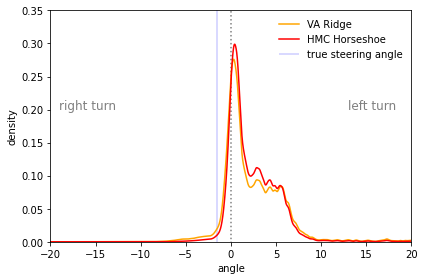

In [12]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[1], color = 'orange', label = 'VA Ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[1], color = 'purple', label = 'VA Horseshoe')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[1], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[1], color = 'orange', label = 'HMC Ridge')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.35)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(all_img_df[all_img_df['path'] == paths[1][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_121_254run1.pdf') 

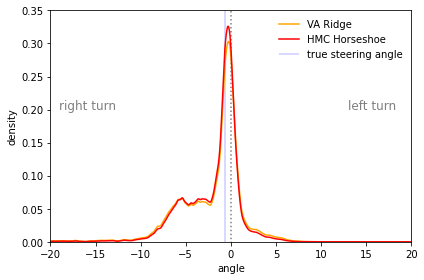

In [13]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[0], color = 'orange', label = 'VA Ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[0], color = 'purple', label = 'VA Horseshoe', linestyle = '-.')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[0], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[0], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.35)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(all_img_df[all_img_df['path'] == paths[0][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_80_436run1.pdf') 

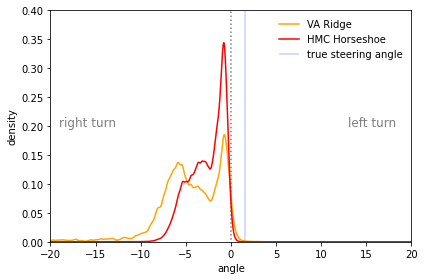

In [14]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[2], color = 'orange', label = 'VA Ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[2], color = 'purple', label = 'VA Horseshoe', linestyle = '-.')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[2], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[2], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.4)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(review_df_test[review_df_test['path'] == paths[2][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_118_977run1.pdf') 

## 4. Plot images

In [15]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

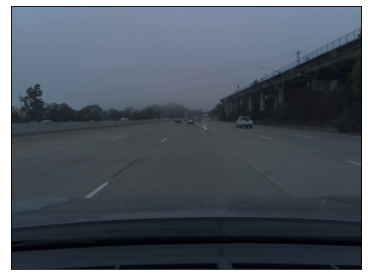

In [22]:
img = imageio.imread(paths[0])
#img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
figure.savefig('../../../data/commaai/calibration/examples_viz/80_436run1.pdf', format='pdf', dpi=900)

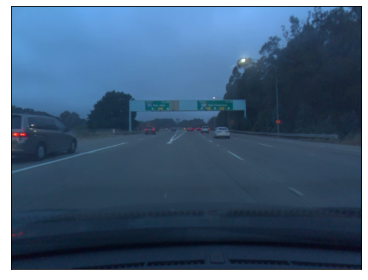

In [23]:
img = imageio.imread(paths[1])
#img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
figure.savefig('../../../data/commaai/calibration/examples_viz/121_254run1.pdf', format='pdf', dpi=900)

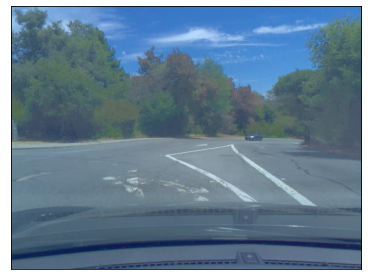

In [24]:
img = change_brightness(imageio.imread(paths[2]), value = 70)
#img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
figure.savefig('../../../data/commaai/calibration/examples_viz/118_977run1.pdf', format='pdf', dpi=900)